# Vision Transformer Classification Task

- 기수: 13기

- 이름: 서승범

- 작성자: 12기 김은희

- Reference: 24-2 RNN+Transformer Assignment / 11기 김정우

본 과제에서는 간단한 Vision Transformer 모델을 Scratch 에서부터 구현해보는 내용을 담고 있습니다.

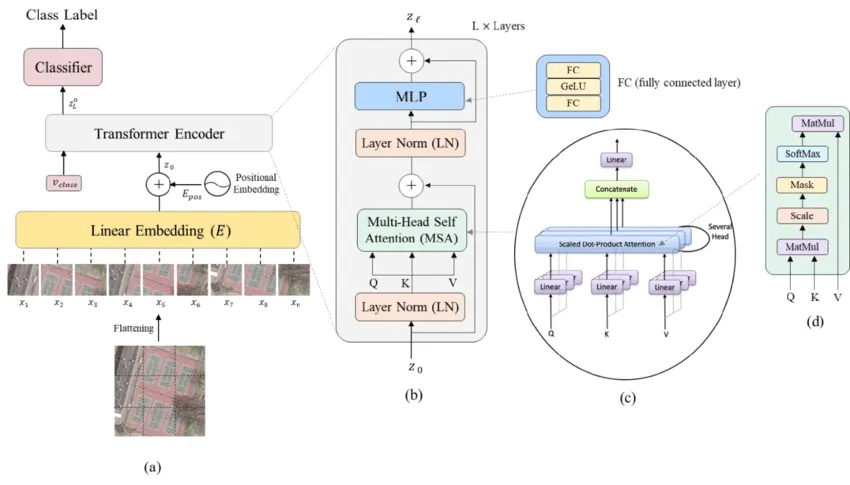

## 1. Setting

In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(2024)
torch.manual_seed(2024)

## 2. Training Format

아래 함수는 기본적인 학습 진행을 위한 템플릿입니다.

In [2]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root = './datasets', train = True, download = True, transform = transform)
    test_set = MNIST(root = './datasets', train = False, download = True, transform = transform)

    train_loader = DataLoader(train_set, shuffle = True, batch_size = 128)
    test_loader = DataLoader(test_set, shuffle = False, batch_size = 128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    model = MyViT((1, 28, 28), n_patches = 7, n_blocks = 2, hidden_d = 8, n_heads = 2, out_d = 10).to(device)
    N_EPOCHS = 20
    LR = 3e-4

    # Training loop
    optimizer = Adam(model.parameters(), lr = LR)
    criterion = CrossEntropyLoss()

    for epoch in trange(N_EPOCHS, desc = "Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc = f"Epoch {epoch + 1} in training", leave = False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0

        for batch in tqdm(test_loader, desc = "Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)

        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

## 3. Forward Process

### 3-1. Patchifying and the linear mapping

기본적으로 하나의 MNIST 데이터는 (1, 28, 28) 으로 구성되어 있습니다.

본 과제에서는 7x7 (49개) 의 patch로 나누는 과정을 진행하게 됩니다.

In [3]:
def patchify(images, n_patches=7):  
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"
    
    patch_size = h // n_patches
    patches = torch.zeros(n, n_patches**2, c*patch_size**2)  # (N, # patch num, # patch dimension)
    

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches


In [4]:
class MyViT(nn.Module):
  def __init__(self, chw = (1, 28, 28), n_patches = 7):
    
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    return patches

In [5]:
if __name__ == '__main__':

  # Current model
  model = MyViT(chw=(1, 28, 28), n_patches = 7)

  x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 16])

torch.Size([7, 49, 16])


이어서 flatten patch에 간단한 linear mapping을 적용해 patch mapping을 진행하고자 합니다.

hidden dimmension은 8차원을 기본으로 하지만, 수정할 수 있습니다.

In [6]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_dim1=8):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_dim1

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

    self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)

    # 1) Linear mapper
    self.input_d = self.chw[0] * self.patch_size[0] *self.patch_size[1] ## TODO : C x n_patches x n_patches ##
    print(self.input_d)
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d) ## TODO : use nn.Linear ##

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    return tokens

In [7]:
if __name__ == '__main__':

  # Current model
  model = MyViT(chw = (1, 28, 28), n_patches = 7)

  x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 16])

16
torch.Size([7, 49, 8])


### 3-2. Adding the Classification Token

ViT에선 Transformer Encoder에 같이 v_class 토큰이 입력됩니다.

 (N, 29, 16)에 해당 토큰이 추가되어 (N, 50, 8) 으로 변환되게 됩니다.

In [8]:
class MyViT(nn.Module):
  def __init__(self, chw = (1, 28, 28), n_patches = 7, hidden_dim1 = 8):

    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_dim1

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d)) # Classification Token을 정의

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
    return tokens

### 3-3. Positional Encoding

ViT에서의 Positional Encoding은 첫 번째 차원에는 고주파수 값을, 두 번째 차원에는 저주파수 값을 추가합니다. (구체적인 내용은 Attention is All you Need 논문을 참고해주세요!)

각 시퀀스에서 토큰 i에 대해 j 번째 좌표에 다음 값을 추가합니다:

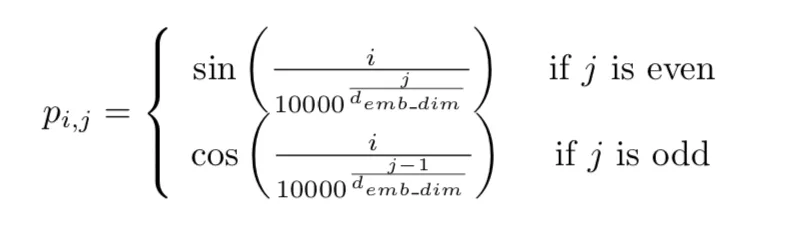

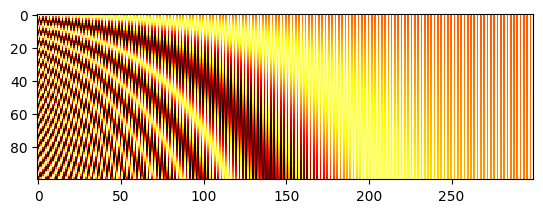

In [9]:
import math
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            if j % 2 == 0:
                result[i][j] = torch.sin(i*torch.exp(torch.tensor(-math.log(1000) * j/d)))## TODO ##
            else:
                result[i][j] = torch.cos(i*torch.exp(torch.tensor(-math.log(1000) * (j-1)/d)))## TODO ##
    return result

if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.show()

해당 부분까지 ViT Class에 더해주게 되면 아래와 같이 진행됩니다.

In [10]:
class MyViT(nn.Module):
  def __init__(self, chw = (1, 28, 28), n_patches = 7, hidden_dim1 = 8):
    
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_dim1

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d)) # Classification Token을 정의

    # 3) Positional embedding
    self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
    self.pos_embed.requires_grad = False

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Adding positional embedding
    pos_embed = self.pos_embed.repeat(images.shape[0], 1, 1)
    out = tokens + pos_embed

    return out

### 3-4. Multi-Head Self Attention

MSA를 위한 클래스는 아래와 같이 구현할 수 있습니다.

In [11]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads
        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)

        result = []

        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        
        return torch.cat([torch.unsqueeze(r, dim = 0) for r in result])

In [12]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio = 4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [13]:
if __name__ == '__main__':
  model = MyViTBlock(hidden_d = 8, n_heads = 2)

  x = torch.randn(7, 50, 8)  # Dummy sequences
  print(model(x).shape)      # torch.Size([7, 50, 8])

torch.Size([7, 50, 8])


In [14]:
class MyViT(nn.Module):
  def __init__(self, chw = (1, 28, 28), n_patches = 7, hidden_dim1 = 8):
    
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_dim1

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
    
    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d)) # Classification Token을 정의

    # 3) Positional embedding
    self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
    self.pos_embed.requires_grad = False

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Adding positional embedding
    pos_embed = self.pos_embed.repeat(images.shape[0], 1, 1)
    out = tokens + pos_embed

    return out

In [15]:
class MyViT(nn.Module):
    def __init__(self, chw = (1, 28, 28), n_patches = 7, n_blocks = 2, hidden_dim1 = 8, n_heads = 2, out_d = 10):

        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # (C, H, W)
        self.n_patches = n_patches
        self.hidden_d = hidden_dim1
        self.n_blocks = n_blocks
        self.n_heads = n_heads

        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classifiation token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d)) # Classification Token을 정의

        # 3) Positional embedding
        self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
            
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(self.hidden_d, n_heads) for _ in range(n_blocks)])


def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.pos_embed.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim = 1)
        
        # Adding positional embedding
        out = tokens + self.pos_embed.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        return out

최종적으로 Classificaion MLP까지 추가하면 ViT를 완성할 수 있습니다.

In [16]:
class MyViT(nn.Module):
    def __init__(self, chw = (1, 28, 28), n_patches = 7, n_blocks = 2, hidden_dim1 = 8, n_heads = 2, out_d = 10):

        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # (C, H, W)
        self.n_patches = n_patches
        self.hidden_d = hidden_dim1
        self.n_blocks = n_blocks
        self.n_heads = n_heads

        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classifiation token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d)) # Classification Token을 정의

        # 3) Positional embedding
        self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
            
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(self.hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim = -1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.pos_embed.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim = 1)
        
        # Adding positional embedding
        out = tokens + self.pos_embed.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]
            
        return self.mlp(out)

## 4. Training

적절히 Epoch와 Learning Rate를 수정하여 loss를 최대한 낮춰보세요!

제출 조건: Test ACC를 75 이상 달성하기 :)

In [17]:
from tqdm import tqdm, trange

def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root = './datasets', train = True, download = True, transform = transform)
    test_set = MNIST(root = './datasets', train = False, download = True, transform = transform)

    train_loader = DataLoader(train_set, shuffle = True, batch_size = 128)
    test_loader = DataLoader(test_set, shuffle = False, batch_size = 128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    model = MyViT((1, 28, 28)).to(device)
    N_EPOCHS = 20
    LR = 0.0001

    # Training loop
    optimizer = Adam(model.parameters(), lr = LR)
    criterion = CrossEntropyLoss()

    for epoch in range(N_EPOCHS):
        train_loss = 0.0
        model.train()  # 모델을 학습 모드로 설정
        progress_bar = tqdm(train_loader, desc = f"Epoch {epoch + 1}/{N_EPOCHS} [Training]", leave = False)

        for batch in progress_bar:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            print(y_hat.shape)
            print(y.shape)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 현재 진행 상태의 loss를 tqdm에 업데이트
            progress_bar.set_postfix({"train_loss": train_loss})

        print(f"Epoch {epoch + 1}/{N_EPOCHS} train loss: {train_loss:.2f}")

        # Test loop
        model.eval()  # 모델을 평가 모드로 설정
        test_loss = 0.0
        correct, total = 0, 0
        test_progress_bar = tqdm(test_loader, desc = f"Epoch {epoch + 1}/{N_EPOCHS} [Testing]", leave = False)

        with torch.no_grad():
            for batch in test_progress_bar:
                x, y = batch
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                loss = criterion(y_hat, y)
                test_loss += loss.detach().cpu().item() / len(test_loader)

                correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
                total += len(x)

                # 현재 진행 상태의 test loss를 tqdm에 업데이트
                test_progress_bar.set_postfix({"test_loss": test_loss})

        accuracy = correct / total * 100
        print(f"Epoch {epoch + 1}/{N_EPOCHS} test loss: {test_loss:.2f}, test accuracy: {accuracy:.2f}%")


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [19]:
model = MyViT((1, 28, 28), n_patches = 7, n_blocks = 2, hidden_dim1 = 8, n_heads = 2, out_d = 10).to(device)

/tmp/ipykernel_11025/373977896.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))


In [ ]:
if __name__ == "__main__":
    main()

/tmp/ipykernel_11025/373977896.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))


Using device:  cuda (NVIDIA GeForce RTX 3090)


Epoch 1/20 [Training]:   0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   0%|          | 1/469 [00:00<05:39,  1.38it/s, train_loss=0.00491]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   0%|          | 2/469 [00:01<05:23,  1.44it/s, train_loss=0.00983]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   1%|          | 3/469 [00:02<05:12,  1.49it/s, train_loss=0.0147] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   1%|          | 4/469 [00:02<05:04,  1.53it/s, train_loss=0.0197]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   1%|          | 5/469 [00:03<05:02,  1.53it/s, train_loss=0.0246]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   1%|▏         | 6/469 [00:03<04:57,  1.56it/s, train_loss=0.0295]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   1%|▏         | 7/469 [00:04<04:56,  1.56it/s, train_loss=0.0344]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   2%|▏         | 8/469 [00:05<04:57,  1.55it/s, train_loss=0.0394]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   2%|▏         | 9/469 [00:05<04:55,  1.56it/s, train_loss=0.0443]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   2%|▏         | 10/469 [00:06<04:54,  1.56it/s, train_loss=0.0492]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   2%|▏         | 11/469 [00:07<04:53,  1.56it/s, train_loss=0.0541]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   3%|▎         | 12/469 [00:07<04:50,  1.57it/s, train_loss=0.059] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   3%|▎         | 13/469 [00:08<04:48,  1.58it/s, train_loss=0.0639]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   3%|▎         | 14/469 [00:09<04:47,  1.58it/s, train_loss=0.0688]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   3%|▎         | 15/469 [00:09<04:47,  1.58it/s, train_loss=0.0738]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   3%|▎         | 16/469 [00:10<04:46,  1.58it/s, train_loss=0.0787]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   4%|▎         | 17/469 [00:10<04:44,  1.59it/s, train_loss=0.0836]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   4%|▍         | 18/469 [00:11<04:42,  1.59it/s, train_loss=0.0885]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   4%|▍         | 19/469 [00:12<04:43,  1.59it/s, train_loss=0.0934]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   4%|▍         | 20/469 [00:12<04:43,  1.59it/s, train_loss=0.0983]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   4%|▍         | 21/469 [00:13<04:43,  1.58it/s, train_loss=0.103] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   5%|▍         | 22/469 [00:14<04:45,  1.57it/s, train_loss=0.108]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   5%|▍         | 23/469 [00:14<04:45,  1.56it/s, train_loss=0.113]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   5%|▌         | 24/469 [00:15<04:44,  1.56it/s, train_loss=0.118]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   5%|▌         | 25/469 [00:16<04:42,  1.57it/s, train_loss=0.123]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   6%|▌         | 26/469 [00:16<04:44,  1.56it/s, train_loss=0.128]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   6%|▌         | 27/469 [00:17<04:42,  1.56it/s, train_loss=0.133]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   6%|▌         | 28/469 [00:17<04:40,  1.57it/s, train_loss=0.138]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   6%|▌         | 29/469 [00:18<04:39,  1.58it/s, train_loss=0.143]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   6%|▋         | 30/469 [00:19<04:38,  1.58it/s, train_loss=0.147]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   7%|▋         | 31/469 [00:19<04:38,  1.57it/s, train_loss=0.152]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   7%|▋         | 32/469 [00:20<04:37,  1.57it/s, train_loss=0.157]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   7%|▋         | 33/469 [00:21<04:38,  1.56it/s, train_loss=0.162]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   7%|▋         | 34/469 [00:21<04:36,  1.57it/s, train_loss=0.167]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   7%|▋         | 35/469 [00:22<04:36,  1.57it/s, train_loss=0.172]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   8%|▊         | 36/469 [00:23<04:34,  1.58it/s, train_loss=0.177]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   8%|▊         | 37/469 [00:23<04:34,  1.57it/s, train_loss=0.182]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   8%|▊         | 38/469 [00:24<04:32,  1.58it/s, train_loss=0.187]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   8%|▊         | 39/469 [00:24<04:31,  1.58it/s, train_loss=0.192]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   9%|▊         | 40/469 [00:25<04:29,  1.59it/s, train_loss=0.197]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   9%|▊         | 41/469 [00:26<04:45,  1.50it/s, train_loss=0.202]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   9%|▉         | 42/469 [00:26<04:40,  1.52it/s, train_loss=0.206]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   9%|▉         | 43/469 [00:27<04:35,  1.55it/s, train_loss=0.211]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:   9%|▉         | 44/469 [00:28<04:32,  1.56it/s, train_loss=0.216]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  10%|▉         | 45/469 [00:28<04:30,  1.57it/s, train_loss=0.221]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  10%|▉         | 46/469 [00:29<04:28,  1.58it/s, train_loss=0.226]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  10%|█         | 47/469 [00:30<04:26,  1.58it/s, train_loss=0.231]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  10%|█         | 48/469 [00:30<04:26,  1.58it/s, train_loss=0.236]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  10%|█         | 49/469 [00:31<04:26,  1.58it/s, train_loss=0.241]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  11%|█         | 50/469 [00:31<04:24,  1.58it/s, train_loss=0.246]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  11%|█         | 51/469 [00:32<04:22,  1.59it/s, train_loss=0.251]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  11%|█         | 52/469 [00:33<04:21,  1.59it/s, train_loss=0.255]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  11%|█▏        | 53/469 [00:33<04:20,  1.59it/s, train_loss=0.26] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  12%|█▏        | 54/469 [00:34<04:19,  1.60it/s, train_loss=0.265]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  12%|█▏        | 55/469 [00:35<04:19,  1.60it/s, train_loss=0.27] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  12%|█▏        | 56/469 [00:35<04:18,  1.60it/s, train_loss=0.275]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  12%|█▏        | 57/469 [00:36<04:17,  1.60it/s, train_loss=0.28] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  12%|█▏        | 58/469 [00:36<04:17,  1.60it/s, train_loss=0.285]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  13%|█▎        | 59/469 [00:37<04:16,  1.60it/s, train_loss=0.29] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  13%|█▎        | 60/469 [00:38<04:17,  1.59it/s, train_loss=0.295]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  13%|█▎        | 61/469 [00:38<04:16,  1.59it/s, train_loss=0.3]  

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  13%|█▎        | 62/469 [00:39<04:15,  1.59it/s, train_loss=0.305]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  13%|█▎        | 63/469 [00:40<04:14,  1.59it/s, train_loss=0.309]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  14%|█▎        | 64/469 [00:40<04:14,  1.59it/s, train_loss=0.314]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  14%|█▍        | 65/469 [00:41<04:14,  1.59it/s, train_loss=0.319]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  14%|█▍        | 66/469 [00:41<04:13,  1.59it/s, train_loss=0.324]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  14%|█▍        | 67/469 [00:42<04:12,  1.59it/s, train_loss=0.329]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  14%|█▍        | 68/469 [00:43<04:11,  1.59it/s, train_loss=0.334]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  15%|█▍        | 69/469 [00:43<04:10,  1.59it/s, train_loss=0.339]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  15%|█▍        | 70/469 [00:44<04:09,  1.60it/s, train_loss=0.344]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  15%|█▌        | 71/469 [00:45<04:09,  1.60it/s, train_loss=0.349]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  15%|█▌        | 72/469 [00:45<04:08,  1.60it/s, train_loss=0.354]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  16%|█▌        | 73/469 [00:46<04:08,  1.59it/s, train_loss=0.359]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  16%|█▌        | 74/469 [00:46<04:07,  1.59it/s, train_loss=0.363]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  16%|█▌        | 75/469 [00:47<04:07,  1.59it/s, train_loss=0.368]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  16%|█▌        | 76/469 [00:48<04:06,  1.60it/s, train_loss=0.373]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  16%|█▋        | 77/469 [00:48<04:06,  1.59it/s, train_loss=0.378]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  17%|█▋        | 78/469 [00:49<04:05,  1.60it/s, train_loss=0.383]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  17%|█▋        | 79/469 [00:50<04:05,  1.59it/s, train_loss=0.388]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  17%|█▋        | 80/469 [00:50<04:05,  1.59it/s, train_loss=0.393]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  17%|█▋        | 81/469 [00:51<04:05,  1.58it/s, train_loss=0.398]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  17%|█▋        | 82/469 [00:52<04:04,  1.58it/s, train_loss=0.403]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  18%|█▊        | 83/469 [00:52<04:03,  1.59it/s, train_loss=0.408]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  18%|█▊        | 84/469 [00:53<04:01,  1.59it/s, train_loss=0.413]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  18%|█▊        | 85/469 [00:53<04:00,  1.60it/s, train_loss=0.418]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  18%|█▊        | 86/469 [00:54<04:00,  1.59it/s, train_loss=0.422]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  19%|█▊        | 87/469 [00:55<03:59,  1.60it/s, train_loss=0.427]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  19%|█▉        | 88/469 [00:55<03:58,  1.60it/s, train_loss=0.432]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  19%|█▉        | 89/469 [00:56<03:58,  1.59it/s, train_loss=0.437]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  19%|█▉        | 90/469 [00:57<03:57,  1.59it/s, train_loss=0.442]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  19%|█▉        | 91/469 [00:57<03:57,  1.59it/s, train_loss=0.447]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  20%|█▉        | 92/469 [00:58<03:57,  1.59it/s, train_loss=0.452]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  20%|█▉        | 93/469 [00:58<03:56,  1.59it/s, train_loss=0.457]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  20%|██        | 94/469 [00:59<03:55,  1.60it/s, train_loss=0.462]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  20%|██        | 95/469 [01:00<03:54,  1.59it/s, train_loss=0.467]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  20%|██        | 96/469 [01:00<03:52,  1.60it/s, train_loss=0.472]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  21%|██        | 97/469 [01:01<03:52,  1.60it/s, train_loss=0.476]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  21%|██        | 98/469 [01:02<03:51,  1.60it/s, train_loss=0.481]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  21%|██        | 99/469 [01:02<03:50,  1.60it/s, train_loss=0.486]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  21%|██▏       | 100/469 [01:03<03:50,  1.60it/s, train_loss=0.491]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  22%|██▏       | 101/469 [01:03<03:50,  1.60it/s, train_loss=0.496]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  22%|██▏       | 102/469 [01:04<03:49,  1.60it/s, train_loss=0.501]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  22%|██▏       | 103/469 [01:05<03:48,  1.60it/s, train_loss=0.506]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  22%|██▏       | 104/469 [01:05<03:48,  1.60it/s, train_loss=0.511]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  22%|██▏       | 105/469 [01:06<03:49,  1.59it/s, train_loss=0.516]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  23%|██▎       | 106/469 [01:07<03:47,  1.60it/s, train_loss=0.521]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  23%|██▎       | 107/469 [01:07<03:47,  1.59it/s, train_loss=0.526]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  23%|██▎       | 108/469 [01:08<03:46,  1.59it/s, train_loss=0.53] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  23%|██▎       | 109/469 [01:08<03:46,  1.59it/s, train_loss=0.535]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  23%|██▎       | 110/469 [01:09<03:45,  1.59it/s, train_loss=0.54] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  24%|██▎       | 111/469 [01:10<03:44,  1.59it/s, train_loss=0.545]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  24%|██▍       | 112/469 [01:10<03:42,  1.60it/s, train_loss=0.55] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  24%|██▍       | 113/469 [01:11<03:43,  1.59it/s, train_loss=0.555]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  24%|██▍       | 114/469 [01:12<03:42,  1.59it/s, train_loss=0.56] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  25%|██▍       | 115/469 [01:12<03:41,  1.60it/s, train_loss=0.565]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  25%|██▍       | 116/469 [01:13<03:41,  1.59it/s, train_loss=0.57] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  25%|██▍       | 117/469 [01:13<03:40,  1.60it/s, train_loss=0.575]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  25%|██▌       | 118/469 [01:14<03:39,  1.60it/s, train_loss=0.58] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  25%|██▌       | 119/469 [01:15<03:55,  1.49it/s, train_loss=0.585]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  26%|██▌       | 120/469 [01:16<03:49,  1.52it/s, train_loss=0.589]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  26%|██▌       | 121/469 [01:16<03:45,  1.54it/s, train_loss=0.594]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  26%|██▌       | 122/469 [01:17<03:42,  1.56it/s, train_loss=0.599]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  26%|██▌       | 123/469 [01:17<03:40,  1.57it/s, train_loss=0.604]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  26%|██▋       | 124/469 [01:18<03:38,  1.58it/s, train_loss=0.609]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  27%|██▋       | 125/469 [01:19<03:38,  1.58it/s, train_loss=0.614]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  27%|██▋       | 126/469 [01:19<03:36,  1.58it/s, train_loss=0.619]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  27%|██▋       | 127/469 [01:20<03:35,  1.59it/s, train_loss=0.624]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  27%|██▋       | 128/469 [01:21<03:34,  1.59it/s, train_loss=0.629]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  28%|██▊       | 129/469 [01:21<03:34,  1.59it/s, train_loss=0.634]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  28%|██▊       | 130/469 [01:22<03:33,  1.59it/s, train_loss=0.639]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  28%|██▊       | 131/469 [01:22<03:32,  1.59it/s, train_loss=0.643]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  28%|██▊       | 132/469 [01:23<03:32,  1.59it/s, train_loss=0.648]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  28%|██▊       | 133/469 [01:24<03:31,  1.59it/s, train_loss=0.653]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  29%|██▊       | 134/469 [01:24<03:30,  1.59it/s, train_loss=0.658]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  29%|██▉       | 135/469 [01:25<03:30,  1.59it/s, train_loss=0.663]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  29%|██▉       | 136/469 [01:26<03:29,  1.59it/s, train_loss=0.668]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  29%|██▉       | 137/469 [01:26<03:29,  1.59it/s, train_loss=0.673]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  29%|██▉       | 138/469 [01:27<03:28,  1.58it/s, train_loss=0.678]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  30%|██▉       | 139/469 [01:27<03:27,  1.59it/s, train_loss=0.683]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  30%|██▉       | 140/469 [01:28<03:26,  1.60it/s, train_loss=0.688]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  30%|███       | 141/469 [01:29<03:24,  1.60it/s, train_loss=0.693]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  30%|███       | 142/469 [01:29<03:24,  1.60it/s, train_loss=0.697]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  30%|███       | 143/469 [01:30<03:23,  1.60it/s, train_loss=0.702]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  31%|███       | 144/469 [01:31<03:23,  1.60it/s, train_loss=0.707]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  31%|███       | 145/469 [01:31<03:25,  1.58it/s, train_loss=0.712]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  31%|███       | 146/469 [01:32<03:24,  1.58it/s, train_loss=0.717]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  31%|███▏      | 147/469 [01:32<03:22,  1.59it/s, train_loss=0.722]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  32%|███▏      | 148/469 [01:33<03:21,  1.60it/s, train_loss=0.727]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  32%|███▏      | 149/469 [01:34<03:20,  1.60it/s, train_loss=0.732]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  32%|███▏      | 150/469 [01:34<03:19,  1.60it/s, train_loss=0.737]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  32%|███▏      | 151/469 [01:35<03:19,  1.60it/s, train_loss=0.742]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  32%|███▏      | 152/469 [01:36<03:18,  1.60it/s, train_loss=0.746]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  33%|███▎      | 153/469 [01:36<03:17,  1.60it/s, train_loss=0.751]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  33%|███▎      | 154/469 [01:37<03:17,  1.60it/s, train_loss=0.756]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  33%|███▎      | 155/469 [01:37<03:16,  1.60it/s, train_loss=0.761]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  33%|███▎      | 156/469 [01:38<03:15,  1.60it/s, train_loss=0.766]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  33%|███▎      | 157/469 [01:39<03:15,  1.60it/s, train_loss=0.771]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  34%|███▎      | 158/469 [01:39<03:14,  1.60it/s, train_loss=0.776]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  34%|███▍      | 159/469 [01:40<03:13,  1.60it/s, train_loss=0.781]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  34%|███▍      | 160/469 [01:41<03:13,  1.60it/s, train_loss=0.786]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  34%|███▍      | 161/469 [01:41<03:12,  1.60it/s, train_loss=0.791]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  35%|███▍      | 162/469 [01:42<03:11,  1.60it/s, train_loss=0.796]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  35%|███▍      | 163/469 [01:42<03:10,  1.60it/s, train_loss=0.8]  

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  35%|███▍      | 164/469 [01:43<03:11,  1.59it/s, train_loss=0.805]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  35%|███▌      | 165/469 [01:44<03:10,  1.60it/s, train_loss=0.81] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  35%|███▌      | 166/469 [01:44<03:09,  1.60it/s, train_loss=0.815]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  36%|███▌      | 167/469 [01:45<03:08,  1.60it/s, train_loss=0.82] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  36%|███▌      | 168/469 [01:46<03:08,  1.60it/s, train_loss=0.825]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  36%|███▌      | 169/469 [01:46<03:07,  1.60it/s, train_loss=0.83] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  36%|███▌      | 170/469 [01:47<03:06,  1.60it/s, train_loss=0.835]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  36%|███▋      | 171/469 [01:47<03:05,  1.61it/s, train_loss=0.84] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  37%|███▋      | 172/469 [01:48<03:06,  1.59it/s, train_loss=0.845]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  37%|███▋      | 173/469 [01:49<03:06,  1.59it/s, train_loss=0.85] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  37%|███▋      | 174/469 [01:49<03:04,  1.60it/s, train_loss=0.854]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  37%|███▋      | 175/469 [01:50<03:04,  1.60it/s, train_loss=0.859]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  38%|███▊      | 176/469 [01:51<03:02,  1.60it/s, train_loss=0.864]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  38%|███▊      | 177/469 [01:51<03:03,  1.60it/s, train_loss=0.869]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  38%|███▊      | 178/469 [01:52<03:02,  1.59it/s, train_loss=0.874]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  38%|███▊      | 179/469 [01:53<03:03,  1.58it/s, train_loss=0.879]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  38%|███▊      | 180/469 [01:53<03:02,  1.58it/s, train_loss=0.884]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  39%|███▊      | 181/469 [01:54<03:02,  1.57it/s, train_loss=0.889]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  39%|███▉      | 182/469 [01:54<03:01,  1.58it/s, train_loss=0.894]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  39%|███▉      | 183/469 [01:55<03:01,  1.58it/s, train_loss=0.899]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  39%|███▉      | 184/469 [01:56<03:01,  1.57it/s, train_loss=0.904]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  39%|███▉      | 185/469 [01:56<03:00,  1.57it/s, train_loss=0.908]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  40%|███▉      | 186/469 [01:57<03:00,  1.57it/s, train_loss=0.913]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  40%|███▉      | 187/469 [01:58<02:58,  1.58it/s, train_loss=0.918]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  40%|████      | 188/469 [01:58<02:57,  1.59it/s, train_loss=0.923]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  40%|████      | 189/469 [01:59<02:56,  1.59it/s, train_loss=0.928]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  41%|████      | 190/469 [01:59<02:55,  1.59it/s, train_loss=0.933]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  41%|████      | 191/469 [02:00<02:54,  1.60it/s, train_loss=0.938]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  41%|████      | 192/469 [02:01<02:53,  1.60it/s, train_loss=0.943]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  41%|████      | 193/469 [02:01<02:52,  1.60it/s, train_loss=0.948]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  41%|████▏     | 194/469 [02:02<02:52,  1.60it/s, train_loss=0.953]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  42%|████▏     | 195/469 [02:03<02:51,  1.60it/s, train_loss=0.957]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  42%|████▏     | 196/469 [02:03<02:49,  1.61it/s, train_loss=0.962]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  42%|████▏     | 197/469 [02:04<02:58,  1.52it/s, train_loss=0.967]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  42%|████▏     | 198/469 [02:05<02:55,  1.55it/s, train_loss=0.972]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  42%|████▏     | 199/469 [02:05<02:52,  1.56it/s, train_loss=0.977]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  43%|████▎     | 200/469 [02:06<02:51,  1.57it/s, train_loss=0.982]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  43%|████▎     | 201/469 [02:06<02:49,  1.58it/s, train_loss=0.987]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  43%|████▎     | 202/469 [02:07<02:48,  1.58it/s, train_loss=0.992]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  43%|████▎     | 203/469 [02:08<02:47,  1.59it/s, train_loss=0.997]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  43%|████▎     | 204/469 [02:08<02:45,  1.60it/s, train_loss=1]    

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  44%|████▎     | 205/469 [02:09<02:43,  1.61it/s, train_loss=1.01]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  44%|████▍     | 206/469 [02:10<02:42,  1.62it/s, train_loss=1.01]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  44%|████▍     | 207/469 [02:10<02:41,  1.63it/s, train_loss=1.02]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  44%|████▍     | 208/469 [02:11<02:40,  1.63it/s, train_loss=1.02]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  45%|████▍     | 209/469 [02:11<02:39,  1.63it/s, train_loss=1.03]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  45%|████▍     | 210/469 [02:12<02:38,  1.63it/s, train_loss=1.03]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  45%|████▍     | 211/469 [02:13<02:38,  1.63it/s, train_loss=1.04]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  45%|████▌     | 212/469 [02:13<02:37,  1.63it/s, train_loss=1.04]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  45%|████▌     | 213/469 [02:14<02:37,  1.63it/s, train_loss=1.05]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  46%|████▌     | 214/469 [02:14<02:37,  1.62it/s, train_loss=1.05]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  46%|████▌     | 215/469 [02:15<02:36,  1.62it/s, train_loss=1.06]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  46%|████▌     | 216/469 [02:16<02:35,  1.62it/s, train_loss=1.06]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  46%|████▋     | 217/469 [02:16<02:36,  1.61it/s, train_loss=1.07]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  46%|████▋     | 218/469 [02:17<02:35,  1.62it/s, train_loss=1.07]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  47%|████▋     | 219/469 [02:18<02:34,  1.62it/s, train_loss=1.08]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  47%|████▋     | 220/469 [02:18<02:33,  1.63it/s, train_loss=1.08]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  47%|████▋     | 221/469 [02:19<02:32,  1.63it/s, train_loss=1.09]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  47%|████▋     | 222/469 [02:19<02:31,  1.63it/s, train_loss=1.09]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  48%|████▊     | 223/469 [02:20<02:30,  1.64it/s, train_loss=1.09]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  48%|████▊     | 224/469 [02:21<02:29,  1.64it/s, train_loss=1.1] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  48%|████▊     | 225/469 [02:21<02:28,  1.64it/s, train_loss=1.1]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  48%|████▊     | 226/469 [02:22<02:28,  1.64it/s, train_loss=1.11]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  48%|████▊     | 227/469 [02:22<02:27,  1.64it/s, train_loss=1.11]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  49%|████▊     | 228/469 [02:23<02:26,  1.64it/s, train_loss=1.12]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  49%|████▉     | 229/469 [02:24<02:26,  1.64it/s, train_loss=1.12]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  49%|████▉     | 230/469 [02:24<02:25,  1.64it/s, train_loss=1.13]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  49%|████▉     | 231/469 [02:25<02:25,  1.64it/s, train_loss=1.13]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  49%|████▉     | 232/469 [02:25<02:24,  1.64it/s, train_loss=1.14]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  50%|████▉     | 233/469 [02:26<02:24,  1.64it/s, train_loss=1.14]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  50%|████▉     | 234/469 [02:27<02:23,  1.64it/s, train_loss=1.15]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  50%|█████     | 235/469 [02:27<02:22,  1.64it/s, train_loss=1.15]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  50%|█████     | 236/469 [02:28<02:21,  1.64it/s, train_loss=1.16]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  51%|█████     | 237/469 [02:28<02:21,  1.64it/s, train_loss=1.16]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  51%|█████     | 238/469 [02:29<02:20,  1.65it/s, train_loss=1.17]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  51%|█████     | 239/469 [02:30<02:19,  1.64it/s, train_loss=1.17]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  51%|█████     | 240/469 [02:30<02:19,  1.65it/s, train_loss=1.18]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  51%|█████▏    | 241/469 [02:31<02:18,  1.64it/s, train_loss=1.18]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  52%|█████▏    | 242/469 [02:32<02:17,  1.65it/s, train_loss=1.19]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  52%|█████▏    | 243/469 [02:32<02:17,  1.64it/s, train_loss=1.19]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  52%|█████▏    | 244/469 [02:33<02:17,  1.64it/s, train_loss=1.2] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  52%|█████▏    | 245/469 [02:33<02:16,  1.64it/s, train_loss=1.2]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  52%|█████▏    | 246/469 [02:34<02:15,  1.64it/s, train_loss=1.21]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  53%|█████▎    | 247/469 [02:35<02:14,  1.65it/s, train_loss=1.21]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  53%|█████▎    | 248/469 [02:35<02:13,  1.65it/s, train_loss=1.22]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  53%|█████▎    | 249/469 [02:36<02:13,  1.65it/s, train_loss=1.22]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  53%|█████▎    | 250/469 [02:36<02:12,  1.65it/s, train_loss=1.23]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  54%|█████▎    | 251/469 [02:37<02:12,  1.65it/s, train_loss=1.23]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  54%|█████▎    | 252/469 [02:38<02:11,  1.65it/s, train_loss=1.24]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  54%|█████▍    | 253/469 [02:38<02:10,  1.65it/s, train_loss=1.24]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  54%|█████▍    | 254/469 [02:39<02:10,  1.65it/s, train_loss=1.25]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  54%|█████▍    | 255/469 [02:39<02:09,  1.65it/s, train_loss=1.25]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  55%|█████▍    | 256/469 [02:40<02:08,  1.66it/s, train_loss=1.26]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  55%|█████▍    | 257/469 [02:41<02:09,  1.63it/s, train_loss=1.26]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  55%|█████▌    | 258/469 [02:41<02:07,  1.65it/s, train_loss=1.27]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  55%|█████▌    | 259/469 [02:42<02:06,  1.65it/s, train_loss=1.27]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  55%|█████▌    | 260/469 [02:42<02:05,  1.66it/s, train_loss=1.28]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  56%|█████▌    | 261/469 [02:43<02:04,  1.67it/s, train_loss=1.28]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  56%|█████▌    | 262/469 [02:44<02:03,  1.67it/s, train_loss=1.29]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  56%|█████▌    | 263/469 [02:44<02:04,  1.66it/s, train_loss=1.29]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  56%|█████▋    | 264/469 [02:45<02:04,  1.65it/s, train_loss=1.3] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  57%|█████▋    | 265/469 [02:45<02:05,  1.63it/s, train_loss=1.3]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  57%|█████▋    | 266/469 [02:46<02:05,  1.62it/s, train_loss=1.31]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  57%|█████▋    | 267/469 [02:47<02:05,  1.61it/s, train_loss=1.31]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  57%|█████▋    | 268/469 [02:47<02:05,  1.60it/s, train_loss=1.32]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  57%|█████▋    | 269/469 [02:48<02:05,  1.60it/s, train_loss=1.32]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  58%|█████▊    | 270/469 [02:49<02:05,  1.59it/s, train_loss=1.33]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  58%|█████▊    | 271/469 [02:49<02:03,  1.60it/s, train_loss=1.33]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  58%|█████▊    | 272/469 [02:50<02:02,  1.61it/s, train_loss=1.34]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  58%|█████▊    | 273/469 [02:50<02:00,  1.62it/s, train_loss=1.34]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  58%|█████▊    | 274/469 [02:51<01:59,  1.63it/s, train_loss=1.35]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  59%|█████▊    | 275/469 [02:52<02:05,  1.55it/s, train_loss=1.35]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  59%|█████▉    | 276/469 [02:52<02:02,  1.57it/s, train_loss=1.35]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  59%|█████▉    | 277/469 [02:53<02:00,  1.59it/s, train_loss=1.36]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  59%|█████▉    | 278/469 [02:54<02:00,  1.59it/s, train_loss=1.36]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  59%|█████▉    | 279/469 [02:54<01:59,  1.59it/s, train_loss=1.37]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  60%|█████▉    | 280/469 [02:55<01:59,  1.59it/s, train_loss=1.37]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  60%|█████▉    | 281/469 [02:56<01:57,  1.60it/s, train_loss=1.38]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  60%|██████    | 282/469 [02:56<01:57,  1.59it/s, train_loss=1.38]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  60%|██████    | 283/469 [02:57<01:57,  1.59it/s, train_loss=1.39]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  61%|██████    | 284/469 [02:57<01:56,  1.59it/s, train_loss=1.39]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  61%|██████    | 285/469 [02:58<01:55,  1.59it/s, train_loss=1.4] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  61%|██████    | 286/469 [02:59<01:57,  1.56it/s, train_loss=1.4]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  61%|██████    | 287/469 [02:59<01:56,  1.57it/s, train_loss=1.41]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  61%|██████▏   | 288/469 [03:00<01:55,  1.57it/s, train_loss=1.41]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  62%|██████▏   | 289/469 [03:01<01:54,  1.58it/s, train_loss=1.42]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  62%|██████▏   | 290/469 [03:01<01:52,  1.59it/s, train_loss=1.42]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  62%|██████▏   | 291/469 [03:02<01:50,  1.61it/s, train_loss=1.43]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  62%|██████▏   | 292/469 [03:02<01:49,  1.61it/s, train_loss=1.43]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  62%|██████▏   | 293/469 [03:03<01:48,  1.62it/s, train_loss=1.44]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  63%|██████▎   | 294/469 [03:04<01:47,  1.63it/s, train_loss=1.44]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  63%|██████▎   | 295/469 [03:04<01:46,  1.64it/s, train_loss=1.45]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  63%|██████▎   | 296/469 [03:05<01:45,  1.65it/s, train_loss=1.45]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  63%|██████▎   | 297/469 [03:05<01:44,  1.65it/s, train_loss=1.46]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  64%|██████▎   | 298/469 [03:06<01:43,  1.65it/s, train_loss=1.46]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  64%|██████▍   | 299/469 [03:07<01:43,  1.65it/s, train_loss=1.47]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  64%|██████▍   | 300/469 [03:07<01:42,  1.66it/s, train_loss=1.47]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  64%|██████▍   | 301/469 [03:08<01:41,  1.65it/s, train_loss=1.48]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  64%|██████▍   | 302/469 [03:09<01:41,  1.64it/s, train_loss=1.48]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  65%|██████▍   | 303/469 [03:09<01:40,  1.65it/s, train_loss=1.49]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  65%|██████▍   | 304/469 [03:10<01:40,  1.65it/s, train_loss=1.49]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  65%|██████▌   | 305/469 [03:10<01:39,  1.65it/s, train_loss=1.5] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  65%|██████▌   | 306/469 [03:11<01:39,  1.64it/s, train_loss=1.5]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  65%|██████▌   | 307/469 [03:12<01:38,  1.64it/s, train_loss=1.51]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  66%|██████▌   | 308/469 [03:12<01:37,  1.64it/s, train_loss=1.51]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  66%|██████▌   | 309/469 [03:13<01:36,  1.65it/s, train_loss=1.52]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  66%|██████▌   | 310/469 [03:13<01:36,  1.65it/s, train_loss=1.52]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  66%|██████▋   | 311/469 [03:14<01:35,  1.65it/s, train_loss=1.53]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  67%|██████▋   | 312/469 [03:15<01:35,  1.65it/s, train_loss=1.53]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  67%|██████▋   | 313/469 [03:15<01:34,  1.65it/s, train_loss=1.54]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  67%|██████▋   | 314/469 [03:16<01:33,  1.65it/s, train_loss=1.54]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  67%|██████▋   | 315/469 [03:16<01:33,  1.66it/s, train_loss=1.55]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  67%|██████▋   | 316/469 [03:17<01:32,  1.66it/s, train_loss=1.55]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  68%|██████▊   | 317/469 [03:18<01:31,  1.66it/s, train_loss=1.56]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  68%|██████▊   | 318/469 [03:18<01:31,  1.66it/s, train_loss=1.56]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  68%|██████▊   | 319/469 [03:19<01:30,  1.66it/s, train_loss=1.57]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  68%|██████▊   | 320/469 [03:19<01:30,  1.65it/s, train_loss=1.57]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  68%|██████▊   | 321/469 [03:20<01:29,  1.66it/s, train_loss=1.58]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  69%|██████▊   | 322/469 [03:21<01:28,  1.66it/s, train_loss=1.58]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  69%|██████▉   | 323/469 [03:21<01:28,  1.65it/s, train_loss=1.59]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  69%|██████▉   | 324/469 [03:22<01:27,  1.66it/s, train_loss=1.59]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  69%|██████▉   | 325/469 [03:22<01:26,  1.66it/s, train_loss=1.6] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  70%|██████▉   | 326/469 [03:23<01:26,  1.66it/s, train_loss=1.6]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  70%|██████▉   | 327/469 [03:24<01:25,  1.67it/s, train_loss=1.61]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  70%|██████▉   | 328/469 [03:24<01:24,  1.67it/s, train_loss=1.61]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  70%|███████   | 329/469 [03:25<01:23,  1.68it/s, train_loss=1.61]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  70%|███████   | 330/469 [03:25<01:22,  1.68it/s, train_loss=1.62]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  71%|███████   | 331/469 [03:26<01:21,  1.68it/s, train_loss=1.62]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  71%|███████   | 332/469 [03:27<01:21,  1.68it/s, train_loss=1.63]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  71%|███████   | 333/469 [03:27<01:20,  1.68it/s, train_loss=1.63]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  71%|███████   | 334/469 [03:28<01:20,  1.69it/s, train_loss=1.64]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  71%|███████▏  | 335/469 [03:28<01:19,  1.68it/s, train_loss=1.64]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  72%|███████▏  | 336/469 [03:29<01:18,  1.68it/s, train_loss=1.65]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  72%|███████▏  | 337/469 [03:30<01:18,  1.68it/s, train_loss=1.65]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  72%|███████▏  | 338/469 [03:30<01:18,  1.68it/s, train_loss=1.66]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  72%|███████▏  | 339/469 [03:31<01:17,  1.68it/s, train_loss=1.66]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  72%|███████▏  | 340/469 [03:31<01:17,  1.67it/s, train_loss=1.67]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  73%|███████▎  | 341/469 [03:32<01:16,  1.67it/s, train_loss=1.67]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  73%|███████▎  | 342/469 [03:33<01:15,  1.68it/s, train_loss=1.68]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  73%|███████▎  | 343/469 [03:33<01:15,  1.67it/s, train_loss=1.68]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  73%|███████▎  | 344/469 [03:34<01:14,  1.68it/s, train_loss=1.69]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  74%|███████▎  | 345/469 [03:34<01:14,  1.67it/s, train_loss=1.69]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  74%|███████▍  | 346/469 [03:35<01:13,  1.67it/s, train_loss=1.7] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  74%|███████▍  | 347/469 [03:36<01:12,  1.68it/s, train_loss=1.7]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  74%|███████▍  | 348/469 [03:36<01:12,  1.68it/s, train_loss=1.71]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  74%|███████▍  | 349/469 [03:37<01:11,  1.68it/s, train_loss=1.71]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  75%|███████▍  | 350/469 [03:37<01:10,  1.68it/s, train_loss=1.72]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  75%|███████▍  | 351/469 [03:38<01:10,  1.68it/s, train_loss=1.72]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  75%|███████▌  | 352/469 [03:38<01:09,  1.68it/s, train_loss=1.73]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  75%|███████▌  | 353/469 [03:39<01:13,  1.58it/s, train_loss=1.73]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  75%|███████▌  | 354/469 [03:40<01:11,  1.61it/s, train_loss=1.74]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  76%|███████▌  | 355/469 [03:40<01:09,  1.63it/s, train_loss=1.74]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  76%|███████▌  | 356/469 [03:41<01:09,  1.63it/s, train_loss=1.75]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  76%|███████▌  | 357/469 [03:42<01:08,  1.64it/s, train_loss=1.75]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  76%|███████▋  | 358/469 [03:42<01:07,  1.65it/s, train_loss=1.76]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  77%|███████▋  | 359/469 [03:43<01:06,  1.66it/s, train_loss=1.76]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  77%|███████▋  | 360/469 [03:43<01:05,  1.67it/s, train_loss=1.77]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  77%|███████▋  | 361/469 [03:44<01:04,  1.67it/s, train_loss=1.77]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  77%|███████▋  | 362/469 [03:45<01:04,  1.67it/s, train_loss=1.78]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  77%|███████▋  | 363/469 [03:45<01:03,  1.67it/s, train_loss=1.78]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  78%|███████▊  | 364/469 [03:46<01:02,  1.67it/s, train_loss=1.79]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  78%|███████▊  | 365/469 [03:46<01:02,  1.67it/s, train_loss=1.79]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  78%|███████▊  | 366/469 [03:47<01:01,  1.67it/s, train_loss=1.8] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  78%|███████▊  | 367/469 [03:48<01:00,  1.67it/s, train_loss=1.8]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  78%|███████▊  | 368/469 [03:48<01:00,  1.68it/s, train_loss=1.81]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  79%|███████▊  | 369/469 [03:49<01:00,  1.66it/s, train_loss=1.81]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  79%|███████▉  | 370/469 [03:49<00:59,  1.66it/s, train_loss=1.82]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  79%|███████▉  | 371/469 [03:50<00:59,  1.66it/s, train_loss=1.82]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  79%|███████▉  | 372/469 [03:51<00:58,  1.66it/s, train_loss=1.83]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  80%|███████▉  | 373/469 [03:51<00:57,  1.66it/s, train_loss=1.83]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  80%|███████▉  | 374/469 [03:52<00:57,  1.66it/s, train_loss=1.84]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  80%|███████▉  | 375/469 [03:52<00:56,  1.67it/s, train_loss=1.84]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  80%|████████  | 376/469 [03:53<00:56,  1.65it/s, train_loss=1.85]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  80%|████████  | 377/469 [03:54<00:55,  1.66it/s, train_loss=1.85]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  81%|████████  | 378/469 [03:54<00:54,  1.66it/s, train_loss=1.86]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  81%|████████  | 379/469 [03:55<00:54,  1.66it/s, train_loss=1.86]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  81%|████████  | 380/469 [03:55<00:53,  1.66it/s, train_loss=1.87]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  81%|████████  | 381/469 [03:56<00:53,  1.66it/s, train_loss=1.87]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  81%|████████▏ | 382/469 [03:57<00:52,  1.66it/s, train_loss=1.87]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  82%|████████▏ | 383/469 [03:57<00:51,  1.67it/s, train_loss=1.88]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  82%|████████▏ | 384/469 [03:58<00:51,  1.67it/s, train_loss=1.88]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  82%|████████▏ | 385/469 [03:58<00:50,  1.66it/s, train_loss=1.89]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  82%|████████▏ | 386/469 [03:59<00:49,  1.66it/s, train_loss=1.89]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  83%|████████▎ | 387/469 [04:00<00:49,  1.67it/s, train_loss=1.9] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  83%|████████▎ | 388/469 [04:00<00:48,  1.67it/s, train_loss=1.9]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  83%|████████▎ | 389/469 [04:01<00:48,  1.67it/s, train_loss=1.91]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  83%|████████▎ | 390/469 [04:01<00:47,  1.66it/s, train_loss=1.91]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  83%|████████▎ | 391/469 [04:02<00:47,  1.66it/s, train_loss=1.92]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  84%|████████▎ | 392/469 [04:03<00:46,  1.66it/s, train_loss=1.92]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  84%|████████▍ | 393/469 [04:03<00:45,  1.66it/s, train_loss=1.93]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  84%|████████▍ | 394/469 [04:04<00:45,  1.66it/s, train_loss=1.93]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  84%|████████▍ | 395/469 [04:04<00:44,  1.66it/s, train_loss=1.94]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  84%|████████▍ | 396/469 [04:05<00:43,  1.66it/s, train_loss=1.94]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  85%|████████▍ | 397/469 [04:06<00:43,  1.66it/s, train_loss=1.95]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  85%|████████▍ | 398/469 [04:06<00:42,  1.66it/s, train_loss=1.95]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  85%|████████▌ | 399/469 [04:07<00:42,  1.66it/s, train_loss=1.96]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  85%|████████▌ | 400/469 [04:07<00:41,  1.66it/s, train_loss=1.96]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  86%|████████▌ | 401/469 [04:08<00:40,  1.67it/s, train_loss=1.97]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  86%|████████▌ | 402/469 [04:09<00:40,  1.67it/s, train_loss=1.97]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  86%|████████▌ | 403/469 [04:09<00:39,  1.66it/s, train_loss=1.98]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  86%|████████▌ | 404/469 [04:10<00:39,  1.66it/s, train_loss=1.98]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  86%|████████▋ | 405/469 [04:10<00:38,  1.66it/s, train_loss=1.99]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  87%|████████▋ | 406/469 [04:11<00:37,  1.67it/s, train_loss=1.99]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  87%|████████▋ | 407/469 [04:12<00:37,  1.66it/s, train_loss=2]   

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  87%|████████▋ | 408/469 [04:12<00:36,  1.66it/s, train_loss=2]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  87%|████████▋ | 409/469 [04:13<00:36,  1.67it/s, train_loss=2.01]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  87%|████████▋ | 410/469 [04:13<00:35,  1.66it/s, train_loss=2.01]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  88%|████████▊ | 411/469 [04:14<00:34,  1.66it/s, train_loss=2.02]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  88%|████████▊ | 412/469 [04:15<00:34,  1.66it/s, train_loss=2.02]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  88%|████████▊ | 413/469 [04:15<00:33,  1.66it/s, train_loss=2.03]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  88%|████████▊ | 414/469 [04:16<00:33,  1.66it/s, train_loss=2.03]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  88%|████████▊ | 415/469 [04:16<00:32,  1.66it/s, train_loss=2.04]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  89%|████████▊ | 416/469 [04:17<00:32,  1.65it/s, train_loss=2.04]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  89%|████████▉ | 417/469 [04:18<00:31,  1.65it/s, train_loss=2.05]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  89%|████████▉ | 418/469 [04:18<00:30,  1.66it/s, train_loss=2.05]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  89%|████████▉ | 419/469 [04:19<00:30,  1.66it/s, train_loss=2.06]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  90%|████████▉ | 420/469 [04:19<00:29,  1.66it/s, train_loss=2.06]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  90%|████████▉ | 421/469 [04:20<00:28,  1.66it/s, train_loss=2.07]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  90%|████████▉ | 422/469 [04:21<00:28,  1.66it/s, train_loss=2.07]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  90%|█████████ | 423/469 [04:21<00:27,  1.66it/s, train_loss=2.08]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  90%|█████████ | 424/469 [04:22<00:27,  1.66it/s, train_loss=2.08]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  91%|█████████ | 425/469 [04:22<00:26,  1.66it/s, train_loss=2.09]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  91%|█████████ | 426/469 [04:23<00:25,  1.66it/s, train_loss=2.09]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  91%|█████████ | 427/469 [04:24<00:25,  1.67it/s, train_loss=2.1] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  91%|█████████▏| 428/469 [04:24<00:24,  1.67it/s, train_loss=2.1]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  91%|█████████▏| 429/469 [04:25<00:23,  1.67it/s, train_loss=2.11]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  92%|█████████▏| 430/469 [04:25<00:23,  1.67it/s, train_loss=2.11]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  92%|█████████▏| 431/469 [04:26<00:24,  1.58it/s, train_loss=2.12]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  92%|█████████▏| 432/469 [04:27<00:23,  1.61it/s, train_loss=2.12]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  92%|█████████▏| 433/469 [04:27<00:22,  1.62it/s, train_loss=2.12]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  93%|█████████▎| 434/469 [04:28<00:21,  1.63it/s, train_loss=2.13]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  93%|█████████▎| 435/469 [04:29<00:20,  1.64it/s, train_loss=2.13]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  93%|█████████▎| 436/469 [04:29<00:20,  1.65it/s, train_loss=2.14]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  93%|█████████▎| 437/469 [04:30<00:19,  1.65it/s, train_loss=2.14]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  93%|█████████▎| 438/469 [04:30<00:18,  1.66it/s, train_loss=2.15]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  94%|█████████▎| 439/469 [04:31<00:18,  1.65it/s, train_loss=2.15]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  94%|█████████▍| 440/469 [04:32<00:17,  1.65it/s, train_loss=2.16]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  94%|█████████▍| 441/469 [04:32<00:16,  1.66it/s, train_loss=2.16]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  94%|█████████▍| 442/469 [04:33<00:16,  1.66it/s, train_loss=2.17]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  94%|█████████▍| 443/469 [04:33<00:15,  1.66it/s, train_loss=2.17]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  95%|█████████▍| 444/469 [04:34<00:15,  1.66it/s, train_loss=2.18]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  95%|█████████▍| 445/469 [04:35<00:14,  1.66it/s, train_loss=2.18]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  95%|█████████▌| 446/469 [04:35<00:13,  1.66it/s, train_loss=2.19]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  95%|█████████▌| 447/469 [04:36<00:13,  1.66it/s, train_loss=2.19]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  96%|█████████▌| 448/469 [04:36<00:12,  1.66it/s, train_loss=2.2] 

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  96%|█████████▌| 449/469 [04:37<00:11,  1.67it/s, train_loss=2.2]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  96%|█████████▌| 450/469 [04:38<00:11,  1.67it/s, train_loss=2.21]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  96%|█████████▌| 451/469 [04:38<00:10,  1.66it/s, train_loss=2.21]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  96%|█████████▋| 452/469 [04:39<00:10,  1.66it/s, train_loss=2.22]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  97%|█████████▋| 453/469 [04:39<00:09,  1.66it/s, train_loss=2.22]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  97%|█████████▋| 454/469 [04:40<00:09,  1.67it/s, train_loss=2.23]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  97%|█████████▋| 455/469 [04:41<00:08,  1.66it/s, train_loss=2.23]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  97%|█████████▋| 456/469 [04:41<00:07,  1.67it/s, train_loss=2.24]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  97%|█████████▋| 457/469 [04:42<00:07,  1.67it/s, train_loss=2.24]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  98%|█████████▊| 458/469 [04:42<00:06,  1.67it/s, train_loss=2.25]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  98%|█████████▊| 459/469 [04:43<00:05,  1.67it/s, train_loss=2.25]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  98%|█████████▊| 460/469 [04:44<00:05,  1.67it/s, train_loss=2.26]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  98%|█████████▊| 461/469 [04:44<00:04,  1.67it/s, train_loss=2.26]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  99%|█████████▊| 462/469 [04:45<00:04,  1.68it/s, train_loss=2.27]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  99%|█████████▊| 463/469 [04:45<00:03,  1.67it/s, train_loss=2.27]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  99%|█████████▉| 464/469 [04:46<00:02,  1.67it/s, train_loss=2.28]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  99%|█████████▉| 465/469 [04:47<00:02,  1.66it/s, train_loss=2.28]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]:  99%|█████████▉| 466/469 [04:47<00:01,  1.66it/s, train_loss=2.29]

torch.Size([128, 10])
torch.Size([128])


Epoch 1/20 [Training]: 100%|█████████▉| 467/469 [04:48<00:01,  1.67it/s, train_loss=2.29]

torch.Size([128, 10])
torch.Size([128])


torch.Size([96, 10])
torch.Size([96])
Epoch 1/20 train loss: 2.30


Epoch 1/20 test loss: 2.30, test accuracy: 11.68%


Epoch 2/20 [Training]:   0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   0%|          | 1/469 [00:00<04:34,  1.71it/s, train_loss=0.00489]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   0%|          | 2/469 [00:01<04:34,  1.70it/s, train_loss=0.00978]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   1%|          | 3/469 [00:01<04:36,  1.69it/s, train_loss=0.0147] 

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   1%|          | 4/469 [00:02<04:34,  1.69it/s, train_loss=0.0196]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   1%|          | 5/469 [00:02<04:34,  1.69it/s, train_loss=0.0245]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   1%|▏         | 6/469 [00:03<04:33,  1.69it/s, train_loss=0.0294]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   1%|▏         | 7/469 [00:04<04:33,  1.69it/s, train_loss=0.0343]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   2%|▏         | 8/469 [00:04<04:32,  1.69it/s, train_loss=0.0392]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   2%|▏         | 9/469 [00:05<04:31,  1.70it/s, train_loss=0.0441]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   2%|▏         | 10/469 [00:05<04:30,  1.69it/s, train_loss=0.049]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   2%|▏         | 11/469 [00:06<04:30,  1.69it/s, train_loss=0.0539]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   3%|▎         | 12/469 [00:07<04:29,  1.69it/s, train_loss=0.0588]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   3%|▎         | 13/469 [00:07<04:27,  1.70it/s, train_loss=0.0637]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   3%|▎         | 14/469 [00:08<04:27,  1.70it/s, train_loss=0.0686]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   3%|▎         | 15/469 [00:08<04:26,  1.70it/s, train_loss=0.0734]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   3%|▎         | 16/469 [00:09<04:25,  1.70it/s, train_loss=0.0783]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   4%|▎         | 17/469 [00:10<04:25,  1.70it/s, train_loss=0.0832]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   4%|▍         | 18/469 [00:10<04:24,  1.71it/s, train_loss=0.0881]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   4%|▍         | 19/469 [00:11<04:23,  1.71it/s, train_loss=0.093] 

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   4%|▍         | 20/469 [00:11<04:23,  1.71it/s, train_loss=0.0979]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   4%|▍         | 21/469 [00:12<04:22,  1.70it/s, train_loss=0.103] 

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   5%|▍         | 22/469 [00:12<04:22,  1.70it/s, train_loss=0.108]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   5%|▍         | 23/469 [00:13<04:20,  1.71it/s, train_loss=0.113]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   5%|▌         | 24/469 [00:14<04:20,  1.71it/s, train_loss=0.118]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   5%|▌         | 25/469 [00:14<04:19,  1.71it/s, train_loss=0.122]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   6%|▌         | 26/469 [00:15<04:19,  1.71it/s, train_loss=0.127]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   6%|▌         | 27/469 [00:15<04:17,  1.72it/s, train_loss=0.132]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   6%|▌         | 28/469 [00:16<04:16,  1.72it/s, train_loss=0.137]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   6%|▌         | 29/469 [00:17<04:16,  1.72it/s, train_loss=0.142]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   6%|▋         | 30/469 [00:17<04:16,  1.71it/s, train_loss=0.147]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   7%|▋         | 31/469 [00:18<04:16,  1.71it/s, train_loss=0.152]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   7%|▋         | 32/469 [00:18<04:15,  1.71it/s, train_loss=0.157]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   7%|▋         | 33/469 [00:19<04:14,  1.71it/s, train_loss=0.162]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   7%|▋         | 34/469 [00:19<04:14,  1.71it/s, train_loss=0.166]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   7%|▋         | 35/469 [00:20<04:13,  1.71it/s, train_loss=0.171]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   8%|▊         | 36/469 [00:21<04:13,  1.71it/s, train_loss=0.176]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   8%|▊         | 37/469 [00:21<04:13,  1.70it/s, train_loss=0.181]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   8%|▊         | 38/469 [00:22<04:13,  1.70it/s, train_loss=0.186]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   8%|▊         | 39/469 [00:22<04:13,  1.70it/s, train_loss=0.191]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   9%|▊         | 40/469 [00:23<04:12,  1.70it/s, train_loss=0.196]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   9%|▊         | 41/469 [00:24<04:11,  1.70it/s, train_loss=0.201]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   9%|▉         | 42/469 [00:24<04:11,  1.70it/s, train_loss=0.206]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   9%|▉         | 43/469 [00:25<04:14,  1.68it/s, train_loss=0.211]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:   9%|▉         | 44/469 [00:25<04:14,  1.67it/s, train_loss=0.215]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  10%|▉         | 45/469 [00:26<04:13,  1.67it/s, train_loss=0.22] 

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  10%|▉         | 46/469 [00:27<04:13,  1.67it/s, train_loss=0.225]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  10%|█         | 47/469 [00:27<04:11,  1.68it/s, train_loss=0.23] 

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  10%|█         | 48/469 [00:28<04:10,  1.68it/s, train_loss=0.235]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  10%|█         | 49/469 [00:28<04:09,  1.68it/s, train_loss=0.24] 

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  11%|█         | 50/469 [00:29<04:08,  1.68it/s, train_loss=0.245]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  11%|█         | 51/469 [00:30<04:07,  1.69it/s, train_loss=0.25] 

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  11%|█         | 52/469 [00:30<04:06,  1.69it/s, train_loss=0.255]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  11%|█▏        | 53/469 [00:31<04:06,  1.68it/s, train_loss=0.26] 

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  12%|█▏        | 54/469 [00:31<04:06,  1.69it/s, train_loss=0.264]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  12%|█▏        | 55/469 [00:32<04:05,  1.69it/s, train_loss=0.269]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  12%|█▏        | 56/469 [00:32<04:04,  1.69it/s, train_loss=0.274]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  12%|█▏        | 57/469 [00:33<04:04,  1.69it/s, train_loss=0.279]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  12%|█▏        | 58/469 [00:34<04:04,  1.68it/s, train_loss=0.284]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  13%|█▎        | 59/469 [00:34<04:03,  1.68it/s, train_loss=0.289]

torch.Size([128, 10])
torch.Size([128])


Epoch 2/20 [Training]:  13%|█▎        | 60/469 [00:35<04:03,  1.68it/s, train_loss=0.294]